In [687]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import pandas_ta as ta
import pickle
from sklearn.metrics import mean_squared_error

In [688]:
import warnings
warnings.filterwarnings("ignore")

In [689]:
import sys
import os
from datetime import datetime, timedelta
sys.path.insert(1, '/home/krystian/Repos/XTB-Trader/utility')
sys.path.insert(1, '/home/krystian/Repos/XTB-Trader')
from XTBClient.api import XTBClient, PERIOD
from utility import utility 

def get_data_for_symbol(symbol):
    c = XTBClient()
    c.login(os.environ.get("XTB_user_num"), os.environ.get("XTB_pass"))
    df = c.get_candles_in_range(symbol, PERIOD.FIFTEEN_MINUTES.value, start=datetime.now() - timedelta(days=365))
    c.logout()
    
    df = df.reset_index()
    df.rename(columns={"timestamp": "date"}, inplace=True)
    
    df['date'] = df['date'].apply(pd.to_datetime)
    df.set_index('date',inplace=True)
    # df.drop([col for col in df.columns if col != "close"], axis=1, inplace=True)
    return df

def import_csv(name):
    df = pd.read_csv(name, sep=';')
    df.columns = ["date","open","high","low","close", "volume"]
    df.date = pd.to_datetime(df.date)
    df.drop(columns="volume", inplace=True)
    df.set_index('date', inplace=True, drop=True)
    return df

In [690]:
def trend_accuracy(real, preds):
    df = pd.DataFrame({"real": real, "preds": preds})
    return len(df[df.real * df.preds > 0]) / len(df)

# Data import

In [691]:
# df = yf.download(tickers = 'EURUSD=x', period='1y', interval='15m')
df = get_data_for_symbol("EURUSD")
df.index.rename("Date", inplace=True)
df.rename(columns={col: col.lower() for col in df.columns}, inplace=True)
df.index.rename(df.index.name.lower(), inplace=True)
df

,open,close,high,low,volume
date,,,,,
2023-01-01 22:00:00,1.07058,1.06932,1.07086,1.06932,187.0
2023-01-01 22:15:00,1.06932,1.06933,1.06935,1.06906,102.0
2023-01-01 22:30:00,1.06931,1.06900,1.06936,1.06857,798.0
2023-01-01 22:45:00,1.06905,1.06944,1.06981,1.06895,1980.0
2023-01-01 23:00:00,1.06922,1.06777,1.06933,1.06773,285.0
...,...,...,...,...,...
2023-07-03 01:00:00,1.09009,1.09038,1.09042,1.09006,5785.0
2023-07-03 01:15:00,1.09038,1.09055,1.09067,1.09035,5132.0
2023-07-03 01:30:00,1.09054,1.09123,1.09172,1.09054,8240.0


In [692]:
df.ta.indicators(as_list=True);

# Additional Indicators

In [693]:
df['RSI']=ta.rsi(df.close, length=15)
df['EMAF']=ta.ema(df.close, length=20)
df['EMAM']=ta.ema(df.close, length=100)
df['EMAS']=ta.ema(df.close, length=150)
df['EMAS2']=ta.ema(df.close, length=120)

df['gain'] = df['close'].diff()
df['future_gain'] = df['gain'].shift(1)
# df['future'] = df['close'].shift(1)
df = pd.concat([df, ta.stoch(df.high, df.low, df.close)], axis=1)

df.dropna(inplace=True)
df

,open,close,high,low,volume,RSI,EMAF,EMAM,EMAS,EMAS2,gain,future_gain,STOCHk_14_3_3,STOCHd_14_3_3
date,,,,,,,,,,,,,,
2023-01-03 11:15:00,1.05270,1.05261,1.05291,1.05191,12215.0,15.644104,1.057125,1.064082,1.066306,1.064679,-0.00010,-0.00035,4.157572,3.550690
2023-01-03 11:30:00,1.05260,1.05314,1.05357,1.05251,10121.0,20.275578,1.056745,1.063865,1.066132,1.064489,0.00053,-0.00010,8.574807,5.260125
2023-01-03 11:45:00,1.05314,1.05279,1.05349,1.05263,11677.0,19.517384,1.056368,1.063646,1.065955,1.064295,-0.00035,0.00053,12.849630,8.527336
2023-01-03 12:00:00,1.05280,1.05326,1.05330,1.05237,12848.0,23.626454,1.056072,1.063440,1.065787,1.064113,0.00047,-0.00035,19.409084,13.611174
2023-01-03 12:15:00,1.05324,1.05395,1.05397,1.05304,11486.0,29.303880,1.055870,1.063252,1.065630,1.063945,0.00069,0.00047,29.993749,20.750821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 01:00:00,1.09009,1.09038,1.09042,1.09006,5785.0,44.715693,1.090735,1.089450,1.089370,1.089366,0.00029,-0.00038,15.177045,17.550733
2023-07-03 01:15:00,1.09038,1.09055,1.09067,1.09035,5132.0,47.961156,1.090718,1.089472,1.089386,1.089386,0.00017,0.00029,28.461538,19.054523
2023-07-03 01:30:00,1.09054,1.09123,1.09172,1.09054,8240.0,58.421901,1.090766,1.089507,1.089410,1.089416,0.00068,0.00017,49.384615,31.007733


# Train Test split

In [694]:
# train, test = df[:int(len(df)*0.8)], df[int(len(df)*0.8):]
train = df[df.index < df.index.min() + (df.index.max() - df.index.min()) * 0.8]
test = df[df.index >= df.index.min() + (df.index.max() - df.index.min()) * 0.8]

In [695]:
len(train), len(test)

(9847, 2401)

In [696]:
target = 'future_gain'
Y_train = train[target]
X_train = train.drop(target, axis=1)

Y_test = test[target]
X_test = test.drop(target, axis=1)

# Multivariable regression 

In [697]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [698]:
predictions = model.predict(X_test)

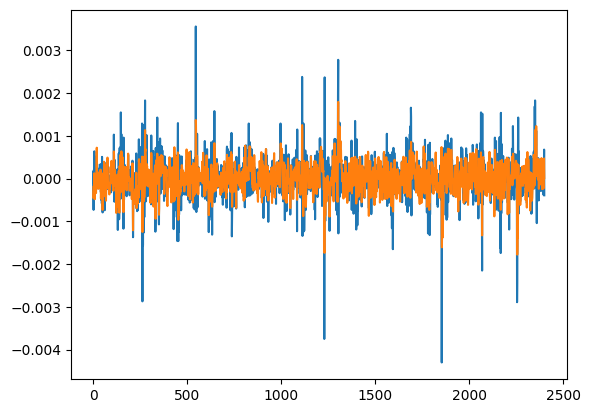

In [699]:
plt.plot(Y_test.values)
plt.plot(predictions)
plt.show()

In [700]:
rms = mean_squared_error(Y_test.values, predictions, squared=False)
rms

0.000338452390026319

In [701]:
trend_accuracy(Y_test.values, predictions)

0.7217825905872554

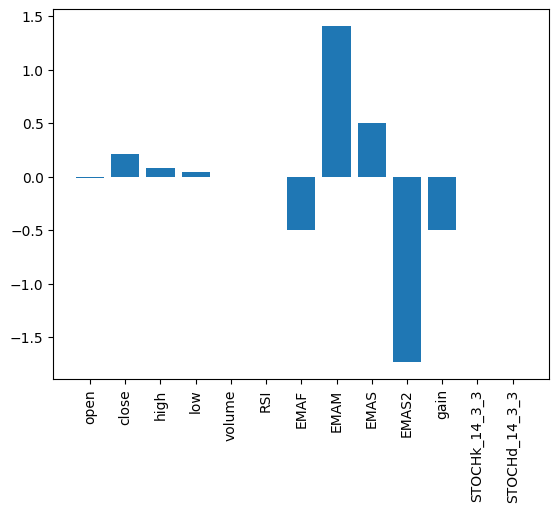

In [702]:
importance = model.coef_

plt.bar(model.feature_names_in_, importance )
plt.xticks(rotation='vertical');

# XGBoost

In [703]:
from numpy import loadtxt
from xgboost import XGBRegressor

In [704]:
model = XGBRegressor()

model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [705]:
predictions = model.predict(X_test)

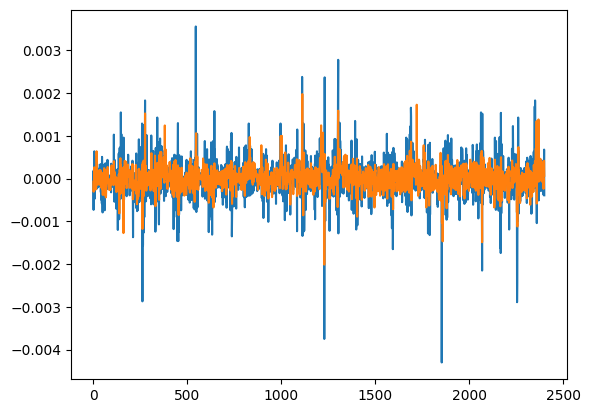

In [706]:
plt.plot(Y_test.values)
plt.plot(predictions)
plt.show()

In [707]:
rms = mean_squared_error(Y_test.values, predictions, squared=False)
rms

0.0003623453055708204

In [708]:
trend_accuracy(Y_test.values, predictions)

0.7030403998334027

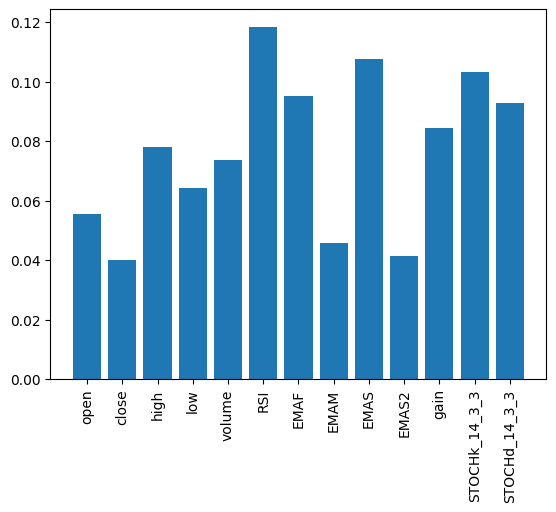

In [709]:
plt.bar(X_train.columns, model.feature_importances_)
plt.xticks(rotation='vertical')
plt.show()

In [710]:
pickle.dump(model, open(os.path.join("../", "models", "main_model.pkl"), 'wb'))

# Catboost

In [677]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=5,
                          learning_rate=1,
                          depth=2)

model.fit(X_train, Y_train)

predictions = model.predict(X_test)

0:	learn: 0.0005473	total: 1.99ms	remaining: 7.96ms
1:	learn: 0.0005416	total: 4.21ms	remaining: 6.31ms
2:	learn: 0.0005365	total: 6.15ms	remaining: 4.1ms
3:	learn: 0.0005268	total: 7.96ms	remaining: 1.99ms
4:	learn: 0.0005218	total: 9.72ms	remaining: 0us


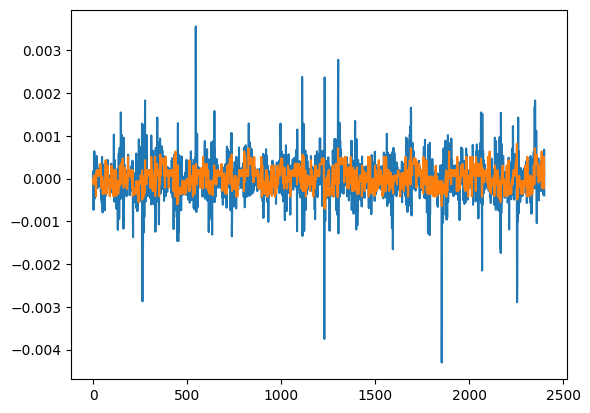

In [678]:
plt.plot(Y_test.values)
plt.plot(predictions)
plt.show()

In [679]:
rms = mean_squared_error(Y_test.values, predictions, squared=False)
rms

0.00041744650378649275

In [680]:
trend_accuracy(Y_test, predictions)

0.5985006247396918

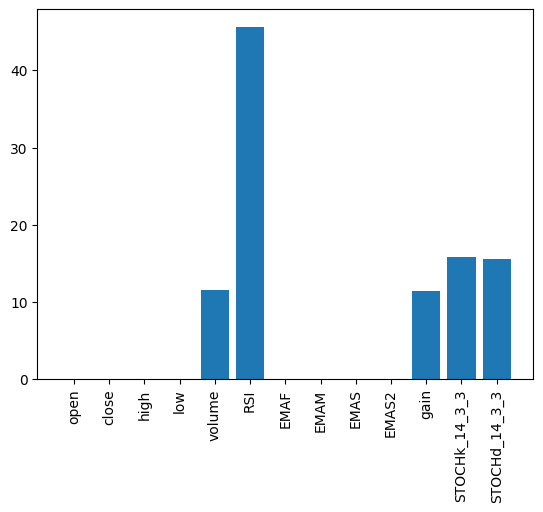

In [681]:
plt.bar(X_train.columns, model.feature_importances_)
plt.xticks(rotation='vertical')
plt.show()

In [625]:
result = pd.DataFrame({"real": Y_test, "pred": predictions})

In [650]:
def is_trade(row):
    if row > 0.0001:
        return 1
    elif row < -0.0001:
        return -1
    else:
        return 0

In [651]:
result['signal'] = result.pred.apply(is_trade) 

if result.iloc[-1].pred > 0.0001:
    print("Trade")

In [652]:
result

,real,pred,signal
date,,,
2023-05-28 21:00:00,0.00015,-0.000008,0
2023-05-28 21:15:00,-0.00073,-0.000134,-1
2023-05-28 21:30:00,0.00020,-0.000008,0
2023-05-28 21:45:00,-0.00011,-0.000008,0
2023-05-28 22:00:00,-0.00018,0.000069,0
...,...,...,...
2023-07-03 01:00:00,-0.00038,-0.000232,-1
2023-07-03 01:15:00,0.00029,-0.000071,0
2023-07-03 01:30:00,0.00017,0.000510,1


In [653]:
result[result.signal != 0]

,real,pred,signal
date,,,
2023-05-28 21:15:00,-0.00073,-0.000134,-1
2023-05-28 22:45:00,-0.00047,-0.000134,-1
2023-05-28 23:00:00,-0.00002,-0.000134,-1
2023-05-28 23:15:00,0.00030,-0.000134,-1
2023-05-28 23:30:00,0.00004,-0.000134,-1
...,...,...,...
2023-07-03 00:00:00,-0.00012,0.000132,1
2023-07-03 00:45:00,-0.00022,-0.000108,-1
2023-07-03 01:00:00,-0.00038,-0.000232,-1


In [683]:
loaded_model = pickle.load(open(filename, 'rb'))

In [724]:
class MAModel:
    def __init__(self, means: list):
         self.means = means

    def predict(self, df):
        target = df["close"]

        ma_cols = []
        for i, mean in enumerate(self.means):
            name = "MA_" + str(mean)
            df[name] = target.rolling(window=mean).mean()
            df[name] = df[name].shift(periods=i)
            ma_cols.append(name)

        df["diff"] = df[ma_cols[0]] - df[ma_cols[1]]
        df["diff"] = df["diff"].astype(float)
        df["diff_prev"] = df["diff"].shift(1)

        df.dropna(how="any", inplace=True)
        df.reset_index(drop=True, inplace=True)

        def is_trade(row):
            if row["diff"] >= 0 and row["diff_prev"] < 0:
                return 1
            if row["diff"] <= 0 and row["diff_prev"] > 0:
                return -1

            return 0

        df["is_trade"] = df.apply(is_trade, axis=1)

        # return df.iloc[0]["is_trade"]
        df_trades = df[df.is_trade != 0].copy().reset_index()

        df_trades["delta"] = (df_trades.close.diff() / 0.0001).shift(-1)
        df_trades["gain"] = (
            df_trades["delta"] * df_trades["is_trade"] + 10 * df_trades["is_trade"]
        )    
        
        return df

In [725]:
model = MAModel([10,20])
model.predict(df)

,open,close,high,low,volume,RSI,EMAF,EMAM,EMAS,EMAS2,gain,future_gain,STOCHk_14_3_3,STOCHd_14_3_3,MA_10,MA_20,diff,diff_prev,is_trade
0,1.06132,1.06139,1.06193,1.06117,14496.0,56.838872,1.060670,1.059067,1.060010,1.059294,0.00008,0.00147,43.294050,30.142543,1.060697,1.061142,-0.000445,-0.000402,0
1,1.06139,1.06103,1.06167,1.06080,15607.0,54.426260,1.060704,1.059106,1.060024,1.059323,-0.00036,0.00008,61.129944,44.921781,1.060691,1.061165,-0.000474,-0.000445,0
2,1.06103,1.06143,1.06144,1.06018,18165.0,56.618400,1.060773,1.059152,1.060043,1.059357,0.00040,-0.00036,62.485876,55.636623,1.060787,1.061138,-0.000352,-0.000474,0
3,1.06144,1.06119,1.06181,1.06114,14822.0,54.920157,1.060813,1.059192,1.060058,1.059388,-0.00024,0.00040,60.225989,61.280603,1.060866,1.061163,-0.000296,-0.000352,0
4,1.06120,1.06106,1.06187,1.06077,23878.0,53.980489,1.060836,1.059229,1.060071,1.059415,-0.00013,-0.00024,61.341159,61.351008,1.060886,1.061098,-0.000212,-0.000296,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12138,1.09009,1.09038,1.09042,1.09006,5785.0,44.715693,1.090735,1.089450,1.089370,1.089366,0.00029,-0.00038,15.177045,17.550733,1.090648,1.090883,-0.000235,-0.000226,0
12139,1.09038,1.09055,1.09067,1.09035,5132.0,47.961156,1.090718,1.089472,1.089386,1.089386,0.00017,0.00029,28.461538,19.054523,1.090609,1.090843,-0.000233,-0.000235,0
12140,1.09054,1.09123,1.09172,1.09054,8240.0,58.421901,1.090766,1.089507,1.089410,1.089416,0.00068,0.00017,49.384615,31.007733,1.090646,1.090812,-0.000166,-0.000233,0
12141,1.09123,1.09084,1.09140,1.09062,6745.0,51.998768,1.090773,1.089533,1.089429,1.089440,-0.00039,0.00068,55.443223,44.429792,1.090651,1.090811,-0.000161,-0.000166,0


In [726]:
filename = os.path.join("../", "models", "main_model.pkl")

In [727]:
pickle.dump(model, open(filename, 'wb'))

In [728]:
loaded_model = pickle.load(open(filename, 'rb'))